### Preprocess

In [1]:
%%capture
!pip install -r requirements.txt --user

In [1]:
path_to_MyModule = '..'

import sys
sys.path.insert(0, path_to_MyModule) 

import pandas as pd

from MyModule.GeneralFunctions import *
from MyModule.SummarizationFunctions import *
from MyModule.SamplingFunctions import *

In [2]:
df = pd.read_excel('..\datos.xlsx')[['ID','texto','desafio']]

In [3]:
# Limpieza
df.drop_duplicates(subset='texto', inplace=True)

# Quitando texto de mas en columna "desafio"
df['desafio'] = df['desafio'].apply(lambda x: re.findall('[0-9]+', x)[0])

# A str
df['texto'] = df['texto'].astype(str)

df.reset_index(inplace=True)

### Create target variable: 
True if the pair comes from the same desafio, false otherwise

In [5]:
# Create a list of tuples containing all possible pairs of strings and ID's
import itertools
id_pairs = list(itertools.combinations(df['ID'].values, 2))

In [6]:
# Create target: 1 if both ID's are from the same desafio, 0 otherwise
target = []
for id1, id2 in id_pairs:
    for desafio in df['desafio'].unique():
        ids_desafio = df[df['desafio']==desafio]['ID'].values
        if id1 in ids_desafio and id2 in ids_desafio:
            target.append(1)
            break
        elif id1 in ids_desafio or id2 in ids_desafio:
            target.append(0)
            break

In [7]:
df_predic = pd.DataFrame([id_pairs, target]).T
df_predic.columns = ['id_pairs','target']

# Are this two ideas from the same desafio?

## Sentence embedding feature

Alternatives:

1. One column for each of the 768 D
2. Same but first reduce dimension with PCA or Lasso/Ridge

In [8]:
model = SentenceTransformer('hiiamsid/sentence_similarity_spanish_es')

In [9]:
original_documents = df['texto'].values

pp_object = Preprocess(lemma=False, stopwords=False, alphanumeric=False, join=False)

pp_documents = pp_object.preprocess(original_documents)

emb_docs = model.encode(pp_documents)

In [10]:
# Add as featrues the document vectors for each document in the pair

first_doc_emb = []
second_doc_emb = []

for pair1, pair2 in df_predic['id_pairs'].values:
    
    indice_pair1 = df[df['ID']==pair1].index[0]
    first_doc_emb.append(emb_docs[indice_pair1])
    
    indice_pair2 = df[df['ID']==pair2].index[0]
    second_doc_emb.append(emb_docs[indice_pair2])
    

# create dataframe
df_emb_1 = pd.DataFrame(first_doc_emb)
df_emb_2 = pd.DataFrame(second_doc_emb)

# rename columns
df_emb_1.columns = [f'first_doc_emb_dim_{i+1}' for i in range(len(first_doc_emb[0]))]
df_emb_2.columns = [f'second_doc_emb_dim_{i+1}' for i in range(len(second_doc_emb[0]))]
df_emb = df_emb_1.join(df_emb_2)

# join with main df
df_predic = df_predic.join(df_emb)

## Sentiment Analysis feature

In [11]:
# Analyze the three sentiments for each doc
from MyModule.SentimentAnalysisFunctions import sentiment_analyzer_3d

all_emotions = {}
analyzer = sentiment_analyzer_3d()

for i, this_id in enumerate(df['ID'].values):
    # print('Doing {} of {}'.format(i, len(df['ID'].values)))
    all_emotions[this_id] = analyzer.predict_sentiment_3d(pp_documents[i])

Doing 0 of 505
Doing 1 of 505
Doing 2 of 505
Doing 3 of 505
Doing 4 of 505
Doing 5 of 505
Doing 6 of 505
Doing 7 of 505
Doing 8 of 505
Doing 9 of 505
Doing 10 of 505
Doing 11 of 505
Doing 12 of 505
Doing 13 of 505
Doing 14 of 505
Doing 15 of 505
Doing 16 of 505
Doing 17 of 505
Doing 18 of 505
Doing 19 of 505
Doing 20 of 505
Doing 21 of 505
Doing 22 of 505
Doing 23 of 505
Doing 24 of 505
Doing 25 of 505
Doing 26 of 505
Doing 27 of 505
Doing 28 of 505
Doing 29 of 505
Doing 30 of 505
Doing 31 of 505
Doing 32 of 505
Doing 33 of 505
Doing 34 of 505
Doing 35 of 505
Doing 36 of 505
Doing 37 of 505
Doing 38 of 505
Doing 39 of 505
Doing 40 of 505
Doing 41 of 505
Doing 42 of 505
Doing 43 of 505
Doing 44 of 505
Doing 45 of 505
Doing 46 of 505
Doing 47 of 505
Doing 48 of 505
Doing 49 of 505
Doing 50 of 505
Doing 51 of 505
Doing 52 of 505
Doing 53 of 505
Doing 54 of 505
Doing 55 of 505
Doing 56 of 505
Doing 57 of 505
Doing 58 of 505
Doing 59 of 505
Doing 60 of 505
Doing 61 of 505
Doing 62 of 505
Do

In [12]:
# Add as featrues the document vectors for each document in the pair

first_doc_pos = []
first_doc_neg = []
first_doc_neu = []

second_doc_pos = []
second_doc_neg = []
second_doc_neu = []

for pair1, pair2 in df_predic['id_pairs'].values:
    
    first_doc_pos.append(all_emotions[pair1][0])
    first_doc_neg.append(all_emotions[pair1][1])
    first_doc_neu.append(all_emotions[pair1][2])
    
    second_doc_pos.append(all_emotions[pair2][0])
    second_doc_neg.append(all_emotions[pair2][1])
    second_doc_neu.append(all_emotions[pair2][2])
    

df_predic['first_doc_pos'] = first_doc_pos
df_predic['first_doc_neg'] = first_doc_neg
df_predic['first_doc_neu'] = first_doc_neu

df_predic['second_doc_pos'] = second_doc_pos
df_predic['second_doc_neg'] = second_doc_neg
df_predic['second_doc_neu'] = second_doc_neu


## Document's Length Feature

In [13]:
all_lengths = {}

for i, this_id in enumerate(df['ID'].values):
    all_lengths[this_id] = len(df['texto'][i].split(' '))

In [14]:
first_doc_len = []
second_doc_len = []

for pair1, pair2 in df_predic['id_pairs'].values:
    
    first_doc_len.append(all_lengths[pair1])
    second_doc_len.append(all_lengths[pair2])

df_predic['first_doc_len'] = first_doc_len
df_predic['second_doc_len'] = second_doc_len

In [15]:
#checkpoint
# df_predic.to_csv('df_predic.csv', index=False)

# Modeling

In [4]:
semilla = 2023

In [5]:
# Helpers

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def print_performance(y_test, y_pred, y_proba=None):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %f' % accuracy)

    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    print('F1 score: %f' % f1)
    
    # ROC
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    print('AUC: %f' % logit_roc_auc)
    
    if y_proba.any():
        fpr, tpr, thresholds = roc_curve(y_test, y_proba[:,1])
        
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [6]:
# Load dfs
df_predic = pd.read_csv('df_predic.csv')
df_predic['id_pairs'] = df_predic['id_pairs'].apply(lambda x: string_to_tuple(x)) # recovering tuples

Scaling

In [7]:
#Importamos StandardScaler de la libreria sklear
from sklearn.preprocessing import StandardScaler

# Instanciamos la funcion para escalar
scaler = StandardScaler()

#Escalamos las variables
scaled = scaler.fit_transform(df_predic.drop(['id_pairs','target'], axis=1))
df_predic_scaled = pd.DataFrame(scaled, columns = df_predic.columns[2:])
df_predic_scaled = df_predic_scaled.join(df_predic[['id_pairs','target']])

train test split

In [8]:
from sklearn.model_selection import train_test_split

# Partición en train y test
y = df_predic_scaled.loc[:, df_predic_scaled.columns == 'target']['target'].values.tolist()
X = df_predic_scaled.loc[:, df_predic_scaled.columns != 'target'].drop('id_pairs', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=semilla)

### Balanceo de clases SMOTE

In [18]:
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=semilla)

In [19]:
columns = X_train.columns
os_data_X, os_data_y = os.fit_resample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['target'])

In [13]:
print("length of oversampled data is ",len(os_data_X))
print("Number of 0 in oversampled data",len(os_data_y[os_data_y['target']==0]))
print("Number of 1",len(os_data_y[os_data_y['target']==1]))
print("Proportion of 0 data in oversampled data is ",len(os_data_y[os_data_y['target']==0])/len(os_data_X))
print("Proportion of 1 data in oversampled data is ",len(os_data_y[os_data_y['target']==1])/len(os_data_X))

length of oversampled data is  173982
Number of 0 in oversampled data 86991
Number of 1 86991
Proportion of 0 data in oversampled data is  0.5
Proportion of 1 data in oversampled data is  0.5


### Balanceo de clases: subsampleo de clase mayoritaria

In [9]:
train = X_train
train['target'] = y_train

positivos = train[train.target == 1]
negativos = train[train.target == 0]

negativos_sub = negativos.sample(n=len(positivos), random_state=semilla)

train_sub = pd.concat([positivos, negativos_sub])

y_train = train_sub.loc[:, train_sub.columns == 'target']
X_train = train_sub.loc[:, train_sub.columns != 'target']
print(len(positivos), len(negativos))

14817 86991


## 1. Logistic Regression

### Simple Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression

In [12]:
# instancia del modelo
logisticRegr = LogisticRegression(max_iter=10000, fit_intercept=True)

# entrenamiento
logisticRegr.fit(X_train, y_train)

# basic performance
y_pred = logisticRegr.predict(X_test)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: 

In [ ]:
# Claramente las clases estan desbalanceadas
targets = df_predic_scaled['target'].value_counts()
print(f'Percentage of class 0: {targets[0]/sum(targets)}')
print_performance(y_test, y_pred)

Percentage of class 0: 0.8544397296872545
Accuracy: 0.858989
Precision: 1.000000
Recall: 0.000279
F1 score: 0.000557


### Logistic Regression with balanced classes

In [20]:
# entrenamiento
logisticRegr.fit(os_data_X, os_data_y)

# basic performance
y_pred = logisticRegr.predict(X_test)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
print_performance(y_test, y_pred)

Accuracy: 0.573354
Precision: 0.170354
Recall: 0.498516
F1 score: 0.253933


## 2. SGDClassifier

In [43]:
#Importamos el modelo y algunas funciones auxiliares
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
import scipy.stats as stats

from sklearn.linear_model import  SGDClassifier

In [49]:
sgd_classifier = SGDClassifier()

In [50]:
# Definimos los parametros
sgd_parametros={'loss': ['hinge','log_loss','modified_hube','squared_hinge','perceptron'],
            'penalty': ['l2', 'l1', 'elasticnet', None],
             'alpha': loguniform(1e-4, 1e0),
             'l1_ratio':stats.uniform(0, 1)
        }

In [55]:
#Ajustamos el modelo
cv = 3
n_iteraciones = 20

sgd_classifier = SGDClassifier()
sgd_random_search = RandomizedSearchCV(estimator=sgd_classifier, n_iter = n_iteraciones, param_distributions = sgd_parametros,
                                   cv = cv, scoring ='accuracy', random_state = semilla )
sgd_random_search.fit(X_train, y_train)

print('Mejor combinación de parámetros %s \n'% sgd_random_search.best_params_)
print('Definición del Modelo %s \n'% sgd_random_search.best_estimator_)
print('Combinaciones Evaluadas %s '% sgd_random_search)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

Mejor combinación de parámetros {'alpha': 0.00999550089604053, 'l1_ratio': 0.3642569891908011, 'loss': 'hinge', 'penalty': 'l2'} 

Definición del Modelo SGDClassifier(alpha=0.00999550089604053, l1_ratio=0.3642569891908011) 

Combinaciones Evaluadas 20 


In [59]:
y_pred = sgd_random_search.best_estimator_.predict(X_test)
print_performance(y_test, y_pred)

Accuracy: 0.516187
Precision: 0.184193
Recall: 0.677097
F1 score: 0.289604


## 3. KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [74]:
# instanciemos y entrenemos el modelo
knn_model = KNeighborsClassifier(n_neighbors=10,weights='uniform')
knn_model.fit(X_train, y_train)


y_pred = knn_model.predict(X_test)
print_performance(y_test, y_pred)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.785518
Precision: 0.391825
Recall: 0.855948
F1 score: 0.537569


In [14]:
# Definimos los parametros
knn_parametros={'n_neighbors':list(range(1, 20)),
                'weights':['uniform', 'distance'],
                'metric':['euclidean', 'chebyshev', 'manhattan']
        }

In [15]:
#Ajustamos el modelo
cv = 3

knn_classifier = KNeighborsClassifier()
knn_grid_search = GridSearchCV(estimator=knn_classifier, param_grid = knn_parametros,
                                   cv=cv, scoring ='accuracy')
knn_grid_search.fit(X_train, y_train)

c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

Mejor combinación de parámetros {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'} 

Definición del Modelo KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance') 



c:\Users\Felipe\miniconda3\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [16]:
print('Mejor combinación de parámetros %s \n'% knn_grid_search.best_params_)
print('Definición del Modelo %s \n'% knn_grid_search.best_estimator_)

Mejor combinación de parámetros {'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'} 

Definición del Modelo KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance') 



Accuracy: 0.796008
Precision: 0.408570
Recall: 0.895063
F1 score: 0.561042
AUC: 0.837093


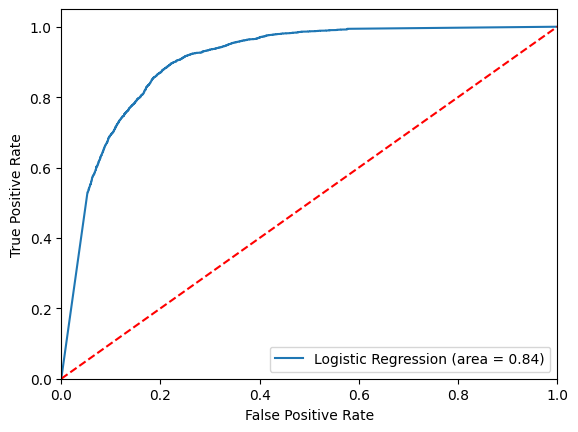

In [13]:
y_pred = knn_grid_search.predict(X_test)
y_pred_proba = knn_grid_search.predict_proba(X_test)
print_performance(y_test, y_pred, y_pred_proba)

## 4. DecisionTree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# instanciemos el modelo y entremoslo en el conjunto de autos
arbol = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=1, min_samples_split=2, ccp_alpha=0)
arbol.fit(X_train,y_train)

y_pred = arbol.predict(X_test)
print_performance(y_train, y_pred)

In [ ]:
# calculando las 5 feature importances mas altas
importances = pd.Series(arbol.feature_importances_).sort_values(ascending=False)[:15]

In [ ]:
f5_names = list(pd.Series(X_train.feature_names)[importances.index.to_list()])
fig, ax = plt.subplots()
importances.plot.barh(ax=ax)
ax.set_yticklabels(f5_names)
ax.invert_yaxis()